____
# Librerias


### Librerías Básicas
- **`Pandas`**: Herramienta poderosa para manipulación y análisis de datos, con estructuras como DataFrames y Series.
- **`Numpy`**: Biblioteca para realizar operaciones matemáticas de alto rendimiento, especialmente útil para trabajar con arrays multidimensionales y álgebra lineal.
- **`Matplotlib.pyplot`**: Biblioteca para crear gráficos básicos, como líneas, dispersión y barras.
- **`Seaborn`**: Extensión de Matplotlib para visualizaciones estadísticas más atractivas y fáciles de interpretar.


### Selección de Modelos y Preprocesamiento
- **`KFold`**: Método de validación cruzada para dividir el conjunto de datos en múltiples pliegues (folds) para entrenar y evaluar modelos.
- **`StandardScaler`**: Escalador que transforma los datos para que tengan una media de 0 y una desviación estándar de 1, mejorando la performance de algoritmos sensibles a escalas.


### Construcción de Modelos con TensorFlow/Keras
- **`l2`**: Regularizador L2 para agregar penalización en los pesos del modelo y evitar el sobreajuste.
- **`Sequential`**: Clase de Keras para construir modelos en capas secuenciales, ideales para redes profundas simples.
- **`Dense`**: Capa completamente conectada para construir redes neuronales densas.
- **`Dropout`**: Capa que apaga aleatoriamente nodos durante el entrenamiento para evitar el sobreajuste.
- **`BatchNormalization`**: Capa que normaliza las entradas para cada mini-lote, acelerando el entrenamiento y mejorando la estabilidad del modelo.


### Callbacks de TensorFlow/Keras
- **`EarlyStopping`**: Callback que detiene el entrenamiento si no se observa mejora en las métricas durante un número definido de épocas.
- **`ReduceLROnPlateau`**: Callback que reduce dinámicamente la tasa de aprendizaje cuando no hay mejoras en las métricas del modelo.


### Métricas y Optimizadores
- **`r2_score`**: Métrica para evaluar el rendimiento de un modelo de regresión, indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es el mejor valor posible).
- **`Adam`**: Optimizador basado en gradientes adaptativos, comúnmente usado en deep learning debido a su eficiencia y simplicidad.


### Gestión de Advertencias
- **`warnings`**: Módulo de Python que permite controlar la emisión de advertencias en el código, útil para evitar mensajes innecesarios durante la ejecución.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam

import warnings

___

# Información sobre el Dataset

### Cargar el DataFrame
- **`pd.read_csv()`**: Función de la librería `Pandas` que permite cargar un archivo CSV en un DataFrame, facilitando la manipulación y análisis de datos.


In [2]:
df = pd.read_csv('Data_Wind.csv')

### Manipulación de la columna `index`
- **`pd.to_datetime()`**: Convierte una columna de texto o enteros en formato datetime, para manejar fechas y horas de manera eficiente.
- **`dt`**: Acceso a componentes individuales de una columna datetime, como `year`, `month`, `day`, o `hour`.
- **`df.drop()`**: Elimina columnas o filas específicas del DataFrame. En este caso, se elimina la columna `index` después de extraer sus características.


In [3]:
df['index'] = pd.to_datetime(df['index'])

df['year'] = df['index'].dt.year
df['month'] = df['index'].dt.month
df['day'] = df['index'].dt.day
df['hour'] = df['index'].dt.hour
df = df.drop('index', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58496 entries, 0 to 58495
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   site                      58496 non-null  int64  
 1   ActivePower_value_KWh     58496 non-null  float64
 2   AmbientTemperature_value  58496 non-null  float64
 3   NacelleAngle_value        58496 non-null  float64
 4   RotorSpeed_value          58496 non-null  float64
 5   WindDirection_value       58496 non-null  float64
 6   WindSpeed_value           58429 non-null  float64
 7   year                      58496 non-null  int32  
 8   month                     58496 non-null  int32  
 9   day                       58496 non-null  int32  
 10  hour                      58496 non-null  int32  
dtypes: float64(6), int32(4), int64(1)
memory usage: 4.0 MB


### Identificación de valores nulos
- **`df.isnull()`**: Genera un DataFrame booleano donde `True` indica valores nulos.
- **`.sum()`**: Suma los valores nulos por columna, permitiendo identificar cuántos faltan en cada una.


In [4]:
nulos = df.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

site                         0
ActivePower_value_KWh        0
AmbientTemperature_value     0
NacelleAngle_value           0
RotorSpeed_value             0
WindDirection_value          0
WindSpeed_value             67
year                         0
month                        0
day                          0
hour                         0
dtype: int64


### Imputación de valores faltantes
- **`df.fillna()`**: Rellena valores nulos con un valor especificado. Aquí, se utiliza el promedio de la columna `WindSpeed_value` para reemplazar sus valores faltantes.
- **`df.mean()`**: Calcula el promedio de los valores no nulos en una columna o DataFrame.


In [5]:
df['WindSpeed_value'] = df['WindSpeed_value'].fillna(df['WindSpeed_value'].mean())

In [6]:
nulos = df.isnull().sum()

# Mostrar cuántos valores nulos hay por columna
print(nulos)

site                        0
ActivePower_value_KWh       0
AmbientTemperature_value    0
NacelleAngle_value          0
RotorSpeed_value            0
WindDirection_value         0
WindSpeed_value             0
year                        0
month                       0
day                         0
hour                        0
dtype: int64


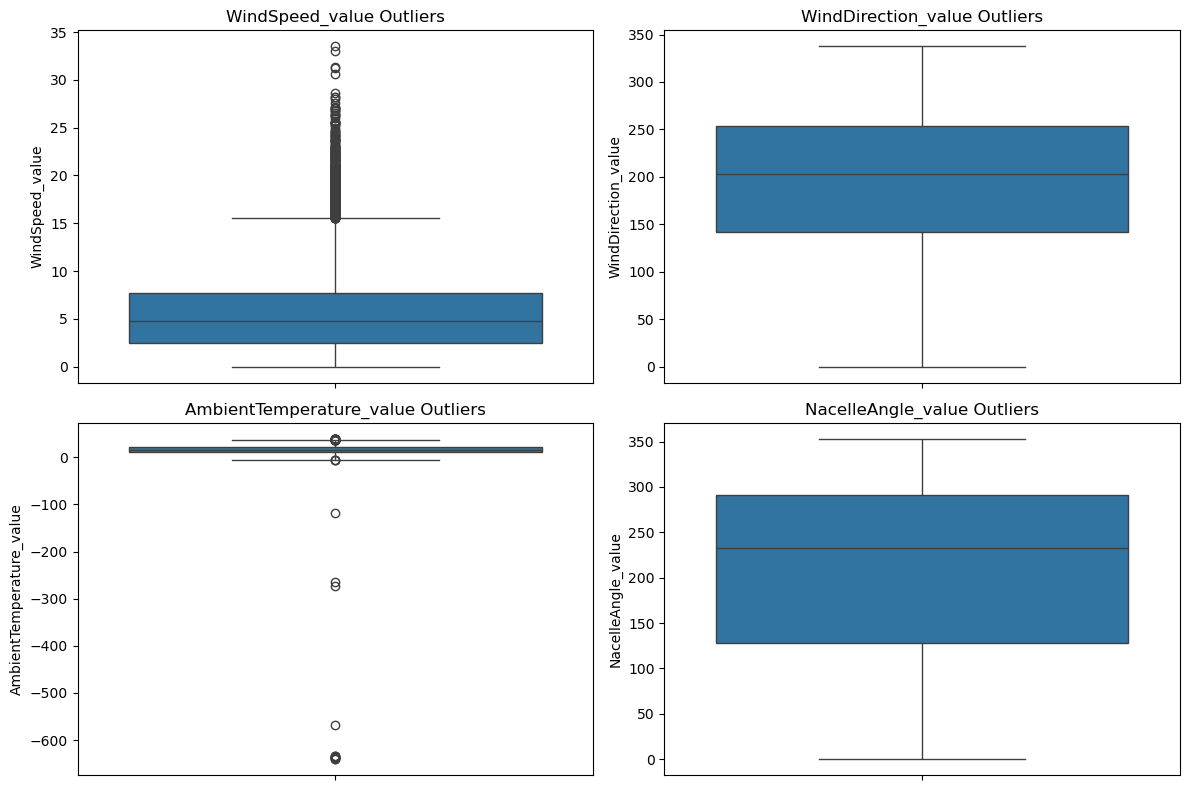

In [9]:
variables = ['WindSpeed_value', 'WindDirection_value', 'AmbientTemperature_value', 'NacelleAngle_value']

# Boxplot para detectar outliers
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=var)
    plt.title(f'{var} Outliers')
plt.tight_layout()
plt.show()

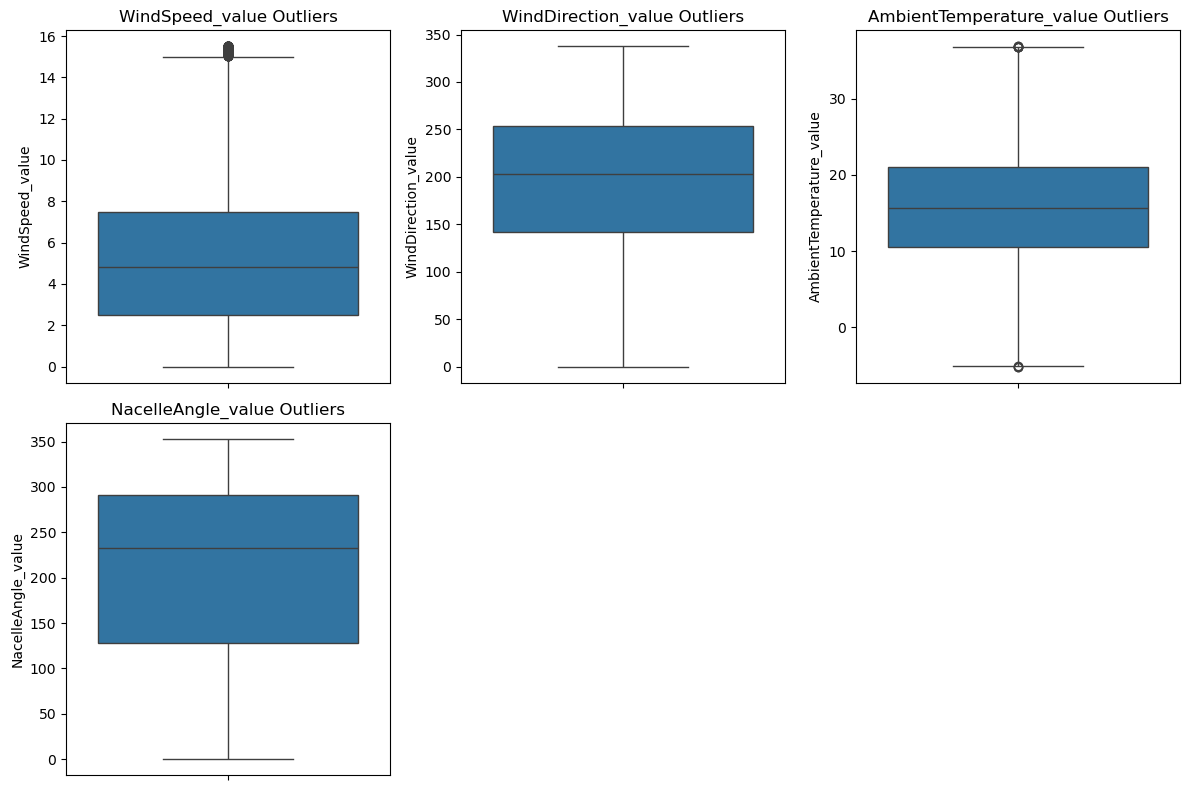

In [ ]:
# 2. Imputar valores atípicos con la media
for var in variables:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[var] = df[var].apply(lambda x: df[var].mean() if x < lower_bound or x > upper_bound else x)
    
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=var)
    plt.title(f'{var} Outliers')
plt.tight_layout()
plt.show()

____

# Modelo W_DL (Dense Neural Network)


In [11]:
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

X_ker = df[['WindSpeed_value', 'WindDirection_value','year', 'month', 'day', 'hour',
          'AmbientTemperature_value', 'NacelleAngle_value']].values

Y_ker = df['ActivePower_value_KWh'].values

kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_ker):
    # Train-Test split
    X_train_ker, X_test_ker = X_ker[train_index], X_ker[test_index]
    Y_train_ker, Y_test_ker = Y_ker[train_index], Y_ker[test_index]
    
    # Scaling
    scaler_ker = StandardScaler()
    X_train_ker = scaler_ker.fit_transform(X_train_ker)
    X_test_ker = scaler_ker.transform(X_test_ker)
    #joblib.dump(scaler_ker, 'scaler_ker1.pkl')
    
    # Create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_ker.shape[1],), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='relu')) # Output layer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    #model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
    
    # Train model
    history = model.fit(X_train_ker, Y_train_ker, epochs=100, batch_size=32, verbose=0,
                        validation_data=(X_test_ker, Y_test_ker),
                        callbacks=[early_stop, lr_scheduler]) #, model_checkpoint
    
    # Evaluate
    mse, mae = model.evaluate(X_test_ker, Y_test_ker, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    Y_test_pred = model.predict(X_test_ker, verbose=0)
    r2 = r2_score(Y_test_ker, Y_test_pred)
    r2_scores.append(r2)
    
    # Predicciones y cálculo de R²
    Y_pred = model.predict(X_test_ker, verbose=0)
    r2 = r2_score(Y_test_ker, Y_pred)
    r2_scores.append(r2)


# Report Results
print("MSE per fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))
print("MAE per fold:", mae_scores)
print("Average MAE:", np.mean(mae_scores))
print("R² per fold:", r2_scores)
print("Average R²:", np.mean(r2_scores))


MSE per fold: [8598772.0, 7552535.5, 7433317.0, 7690638.5, 7776568.5, 7188879.0, 7943855.0, 8002409.5, 8346324.0, 7660309.0]
Average MSE: 7819360.8
MAE per fold: [1995.260986328125, 1884.160888671875, 1868.5150146484375, 1916.77294921875, 1879.1064453125, 1829.6136474609375, 1937.2911376953125, 1923.1485595703125, 1966.1204833984375, 1879.1810302734375]
Average MAE: 1907.9171142578125
R² per fold: [0.7344432608495264, 0.7344432608495264, 0.7592196831441447, 0.7592196831441447, 0.7657054062267077, 0.7657054062267077, 0.7506383234941256, 0.7506383234941256, 0.7564128382676643, 0.7564128382676643, 0.7809659534982546, 0.7809659534982546, 0.7533626400333074, 0.7533626400333074, 0.7369784025467956, 0.7369784025467956, 0.7333559735401974, 0.7333559735401974, 0.7629899158073469, 0.7629899158073469]
Average R²: 0.7534072397408071


____

# Gráficas de los resultados obtenidos

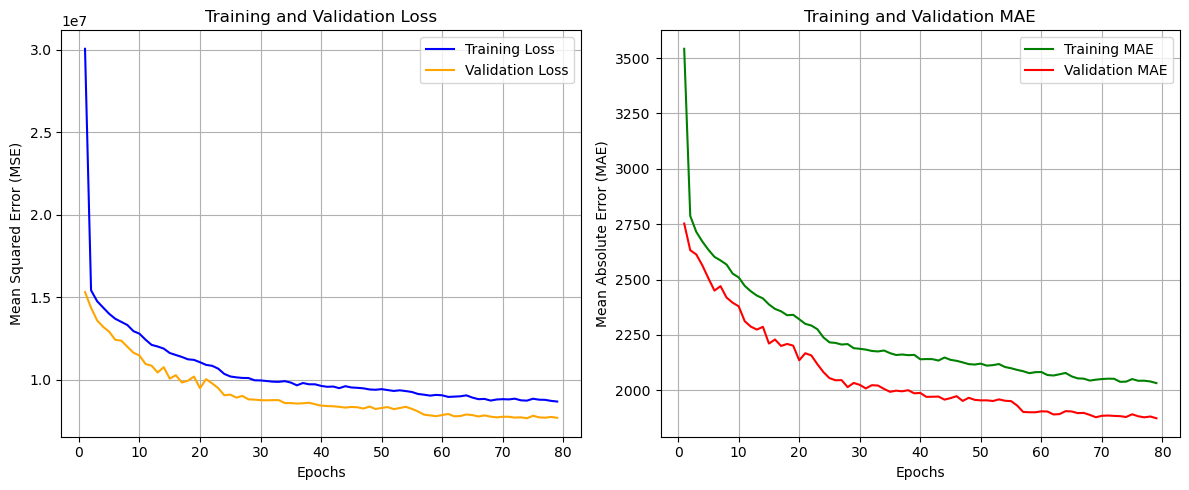

In [12]:
# Extract metrics from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, label='Training MAE', color='green')
plt.plot(epochs, val_mae, label='Validation MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

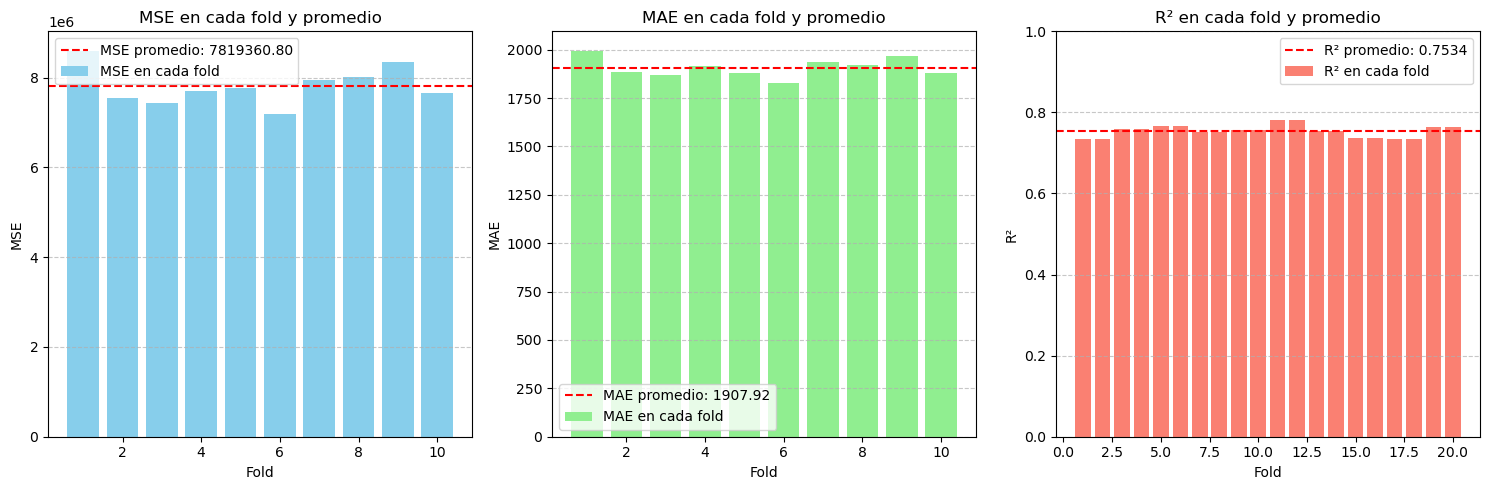

In [13]:
mse_mean = np.mean(mse_scores)
mae_mean = np.mean(mae_scores)
r2_mean = np.mean(r2_scores)


# Generate plots
plt.figure(figsize=(15, 5))

# Plot MSE
plt.subplot(1, 3, 1)
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', label="MSE en cada fold")
plt.axhline(mse_mean, color='red', linestyle='--', label=f"MSE promedio: {mse_mean:.2f}")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("MSE en cada fold y promedio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot MAE
plt.subplot(1, 3, 2)
plt.bar(range(1, len(mae_scores) + 1), mae_scores, color='lightgreen', label="MAE en cada fold")
plt.axhline(mae_mean, color='red', linestyle='--', label=f"MAE promedio: {mae_mean:.2f}")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE en cada fold y promedio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot R²
plt.subplot(1, 3, 3)
plt.bar(range(1, len(r2_scores) + 1), r2_scores, color='salmon', label="R² en cada fold")
plt.axhline(r2_mean, color='red', linestyle='--', label=f"R² promedio: {r2_mean:.4f}")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.ylim(0, 1)  # Limit R² values between 0 and 1
plt.title("R² en cada fold y promedio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

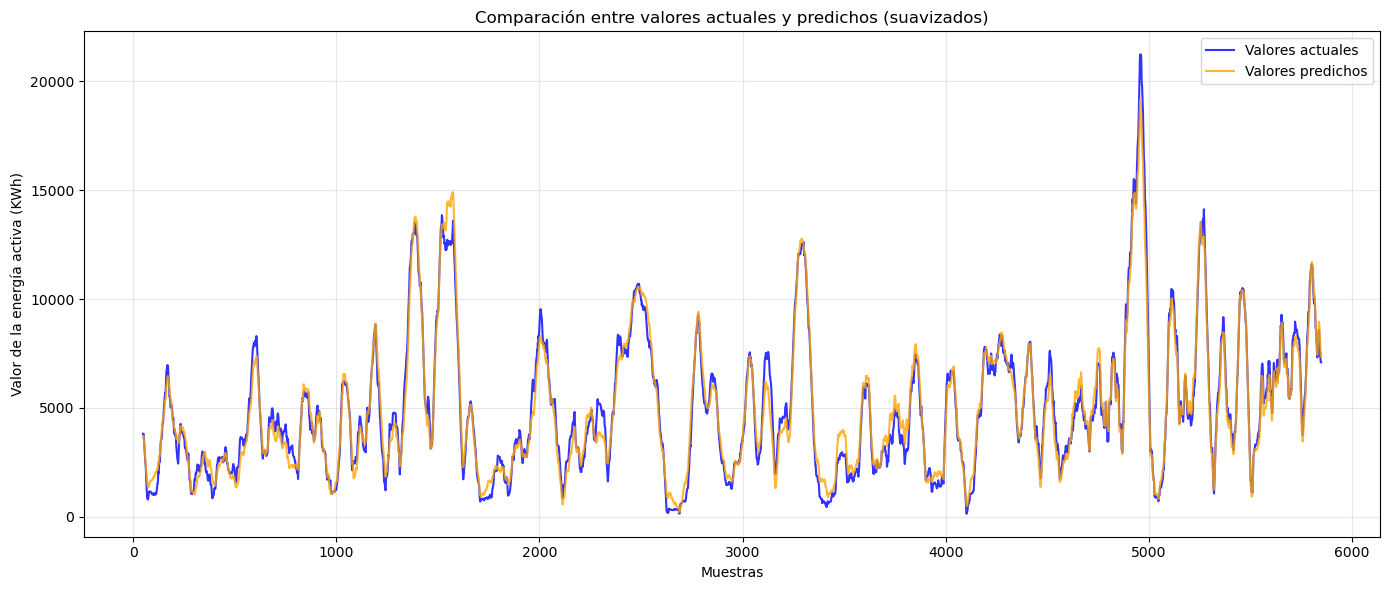

In [14]:
# Number of samples for zoomed-in plot
num_samples = 1000

# Rolling mean window size for smoothing
window_size = 50

# Threshold for large deviations
deviation_threshold = 1000

# Residuals (Actual - Predicted)
residuals = Y_test_ker - Y_pred

# ----- Smoothed Data Plot (Rolling Mean) -----
Y_pred_flattened = Y_pred.ravel()

# Apply a rolling mean for smoother visualization
window_size = 50  # Size of the rolling window
Y_test_smoothed = pd.Series(Y_test_ker).rolling(window=window_size).mean()
Y_pred_smoothed = pd.Series(Y_pred_flattened).rolling(window=window_size).mean()

plt.figure(figsize=(14, 6))
plt.plot(Y_test_smoothed, label='Valores actuales', color='blue', alpha=0.8)
plt.plot(Y_pred_smoothed, label='Valores predichos', color='orange', alpha=0.8)
plt.title('Comparación entre valores actuales y predichos (suavizados)')
plt.xlabel('Muestras')
plt.ylabel('Valor de la energía activa (KWh)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()